In [1]:
# import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, execute
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

from qiskit_ionq import IonQProvider 

#Call provider and set token value
# provider = IonQProvider(token='EDEq7Meo9Re0MIVV2loVBe2hZJCUG4VY')

# numpy
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from ascii import getPotentialNodeDic, setConnection

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_3063/2472294929.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def normalize_data(data):
    for d in data:
        d = d / np.linalg.norm(d)
    return data

# creates random network starting states
def initial_state(n, data):
    temp = QuantumCircuit(n)
    for i in range(n):
        index = np.random.randint(0, n)
        # people_we_consider.append(index)
        # cartesian to spherical
        theta = np.arctan(data[index][1] / data[index][0])
        phi = np.arccos(data[index][2] / np.linalg.norm(data[index]))
        temp.rx(theta, i)
        temp.ry(phi, i)
    return temp

def core_story(n_interactions, mode='sim'):
    player = QuantumRegister(1, name='player')
    n_people = n_interactions+1

    network = QuantumRegister(n_people, name='network')
    bit = ClassicalRegister(1, name='bit')

    qc = QuantumCircuit(player, network, bit)  

    # get the data
    data = pd.read_csv('records.csv').to_numpy()
    data = normalize_data(data)
    all_people = {}
    for i in range(0, len(data)):
        all_people['q' + str(i+1)] = data[i]
    # gives the people in the network the random starting positions
    qc2 = initial_state(n_people, data)
    qc.compose(qc2, np.arange(1, n_people+1), inplace=True)

    for i in range(n_interactions):
        if (mode == 'sim'):
            connect_to = make_contact(all_people)
            add_alice_interaction(qc, connect_to, data)

    # print(qc)
    qc.measure(player, bit)
    return qc


# negative theta is representative of sad story depending on magnitude
# positive theta is good
def life_event():
    circ = QuantumCircuit(1)
    event_types = ['rx', 'rz']
    event = np.random.choice(event_types)
    theta = (np.random.normal() % 1) * np.random.choice([-1, 1]) * np.pi/2
    if event == 'rx':
        circ.rx(theta, 0)
    elif event == 'rz':
        circ.ry(theta, 0)
    return circ

def add_alice_interaction(qc, i, data):
    # fix gate as crx
    if (i != 0):
        theta = (np.sum(data[i]) % 1)  * np.pi
        qc.crx(theta, i, 0)
        le = life_event()
        qc.compose(le, i, inplace=True)

def make_contact(all_people):
    graph_dic = getPotentialNodeDic()
    # print(graph_dic)
    alice_potential_contacts = None
    if (graph_dic.get('q0') != None):
        alice_potential_contacts = graph_dic.get('q0')
    best_score = 0
    best_contact = None

    # print(alice_potential_contacts)
    # add people with highest gain
    for contact in alice_potential_contacts:
        score = np.sum(all_people[contact])
        if(score > best_score):
            best_score = score
            best_contact = contact

    if(best_contact != None):
        setConnection(best_contact)
        best_contact_id = int(best_contact[1:]) - 1
        # print(best_contact_id)
        return best_contact_id
    return 0

def get_user_input(all_people):
    action = str(input('input your choice <person_id  crx|crz>:'))
    action = action.split()
    person_id = int(action[0])
    gate = str((action))
    theta = (np.sum([all_people[i]]) % 1)  * np.pi
    
    #     if gate == 'crx':
    #         circ.crx(theta, network[i], player)
    #     elif gate == 'crz':
    #         circ.crz(theta, network[i], player)
    #     else:
    #         circ.crz(theta, network[i], player)
    


    # gate = [np.random.choice(gates_types) for _ in range(n_starting_people)] # list of gates as str

    # circuits = [qc.copy() for _ in range(n_starting_people)]

    # for i, circ in enumerate(circuits):
    #     theta = (np.sum(data[people_we_consider[i]]) % 1)  * np.pi
    #     if gate[i] == 'crx':
    #         circ.crx(theta, network[i], player)
    #     elif gate[i] == 'cry':
    #         circ.cry(theta, network[i], player)
    #     else:
    #         circ.crz(theta, network[i], player)
        
    #     circ.measure(player, bit)
    #     # plt.figure()
    #     # circ.draw()
    #     print(circ)
        
    # return circuits

# def check_status():
#     # run the circuit
#     better_circuit = circ[0]
#     max_ = -1

#     index_of_person_who_in_circuit = 0

#     for i, circ in enumerate(circuits):
#         backend = BasicAer.get_backend('qasm_simulator')
#         job = execute(circ, backend)
#         result = job.result()
#         counts = result.get_counts()

#         try:
#             if counts['1'] > max_:
#                 max_ = counts['1']
#                 better_circuit = circ
#                 index_of_person_who_in_circuit = i
#         except:
#             pass
        
#         print(counts)

#     print(better_circuit)

#     # remove the person who is in the circuit from our data
#     data = np.delete(data, people_we_consider[index_of_person_who_in_circuit], axis=0)
#     people_we_consider = np.delete(people_we_consider, people_we_consider[index_of_person_who_in_circuit], axis=0)

#     return better_circuit

   ┌───┐   
   │q0 │   
   └─┬─┘   
     │     
   ┌─┘     
   │       
   v       
 ┌───┐ ┌──┐
 │q2 │ │q1│
 └───┘ └──┘
       ┌─────┐        
       │ q0  │        
       └─┬┬──┘        
         ││           
   ┌─────┘│           
   │      │           
   v      v           
 ┌───┐ ┌───┐ ┌──┐ ┌──┐
 │q1 │ │q2 │ │q4│ │q3│
 └───┘ └───┘ └──┘ └──┘
       ┌───────┐       
       │  q0   │       
       └─┬┬──┬─┘       
         ││  │         
   ┌─────┘│  └─┐       
   │      │    │       
   v      v    v       
 ┌───┐ ┌───┐ ┌───┐ ┌──┐
 │q4 │ │q1 │ │q2 │ │q3│
 └───┘ └───┘ └───┘ └──┘
      ┌─────────┐       
      │   q0    │       
      └─┬┬────┬┬┘       
        ││    ││        
   ┌────┘│    └┼─────┐  
   │     │     │     │  
   v     v     v     v  
 ┌───┐ ┌───┐ ┌───┐ ┌───┐
 │q4 │ │q3 │ │q1 │ │q2 │
 └───┘ └───┘ └───┘ └───┘
{'0': 717, '1': 307}


/opt/homebrew/anaconda3/envs/iqh/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


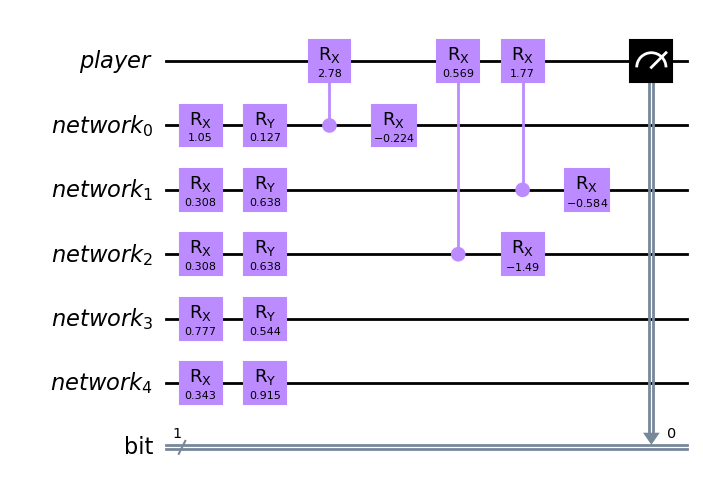

In [3]:
qc = core_story(4)
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw(output='mpl')

In [4]:
n_shots = 50
label = np.arange(20)
overall = []
for n in range(20):
    qc = core_story(n)
    backend = BasicAer.get_backend('qasm_simulator')
    result_arr = []
    for j in range(n_shots):
        job = execute(qc, backend)
        result = job.result()
        counts = result.get_counts()
        if (counts.get('0') == None):
            counts['0'] = 0
        if (counts.get('1') == None):
            counts['1'] = 0
        p0 = counts.get('1')/(counts.get('0') + counts.get('1'))
        result_arr.append(p0)
    overall.append(result_arr)
    result_arr = []

plt.violinplot(overall)
plt.xlabel('Number of connections (n)')
plt.ylabel('Expectation values')



    

# print(counts)
# qc.draw(output='mpl')

KeyboardInterrupt: 